In [1]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle
import collections
import scipy

import keras
import matplotlib.image as mpimg
import matplotlib.patches as matplotlib_patches
import matplotlib.pyplot as plt
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard


from functions_v1 import *

Using TensorFlow backend.


In [2]:
def load_image_pil(infilename, bw=False):
    ''' Read an image from a directory
    INPUTS: 
        infilename: Name of the image (include directory)
        bw = Boolean (1 color image, 0 black and white)
    OUTPUT: 
        data = image file (float 32)
    '''
    img = Image.open(infilename)
    if bw:
        img = img.convert('L')
        
    img = np.array(img)

    return img

def pad_image(image, padding, bw=False):
    """Give an external padding to the original image by mirroring the outside
    INPUTS: 
        image = original image of size (w x h)
        padding = padding size (p)
        bw = True if input image is black and white
    OUTPUTS: 
        padded_image = image with the added reflected padding of size ((w+p) x (h+p))
    
    """
    if bw:
        padded_image = np.lib.pad(image, ((padding, padding), (padding, padding)), 'reflect')
    else:
        padded_image = np.lib.pad(image, ((padding, padding), (padding, padding), (0, 0)), 'reflect')
    return padded_image

def pad_list_image(images, padding, bw=False):
    """Pad a list of images
    INPUTS: 
        images = list of images
        padding = padding size
    OUTPUTS: 
        padded_images = list of padded images
    """
    padded_images = []
    for i in range(len(images)):
        image = pad_image(images[i], padding, bw)
        padded_images.append(image)

    return padded_images

# Load Data

In [3]:
#### Lad Data
n = 100 

# Loaded a set of images
root_dir = "datas/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files.sort()
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
#Read it with PIL as black and white and then change it to numpy array
imgs = [load_image(image_dir + files[i]) for i in range(n)]
bw_imgs = [load_image_pil(image_dir + files[i], bw=True) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])



Loading 100 images
satImage_001.png
Loading 100 groundtruth
satImage_001.png


# Scharr edge detection

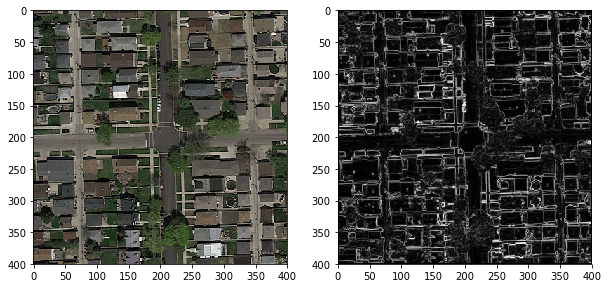

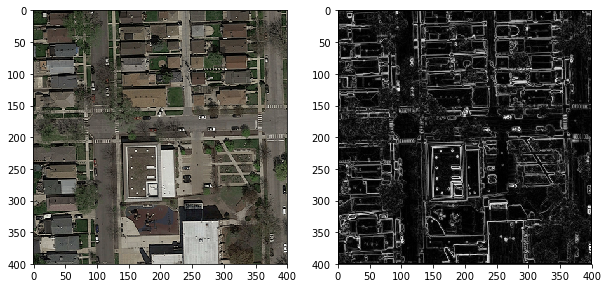

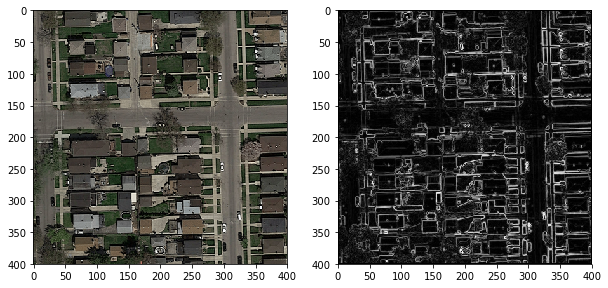

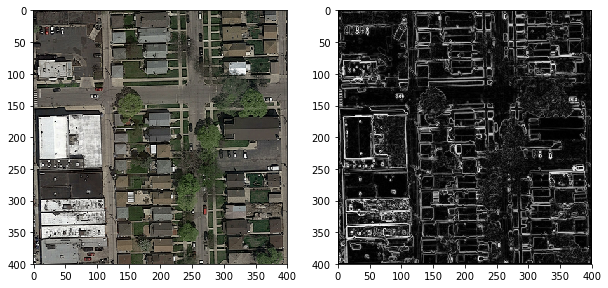

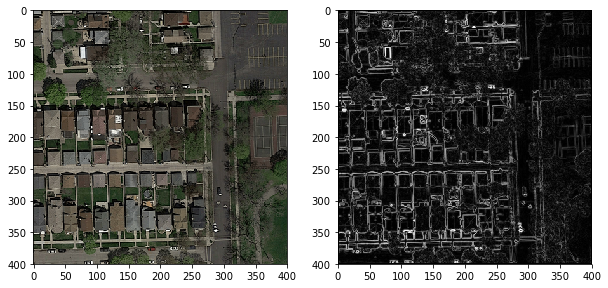

In [4]:
from skimage.filters import scharr

n = 5

for i in range(5):
    bw = bw_imgs[i]
    im = imgs[i]
    
    elevation_map = scharr(bw)

    fig1 = plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(im);
    plt.subplot(1, 2, 2)
    plt.imshow(elevation_map, cmap='Greys_r');

im.shape
elevation_map.shape

sch_imgs = [scharr(bw_im) for bw_im in bw_imgs]

## Padding

Instead of taking the raw 16\*16 patch, we can take a larger patch (padded patch) and then classify the 16\*16 center of that expanded patch.

In order to do that on the border of the image, we have to expand it. One of the way to do that is to mirroring the image

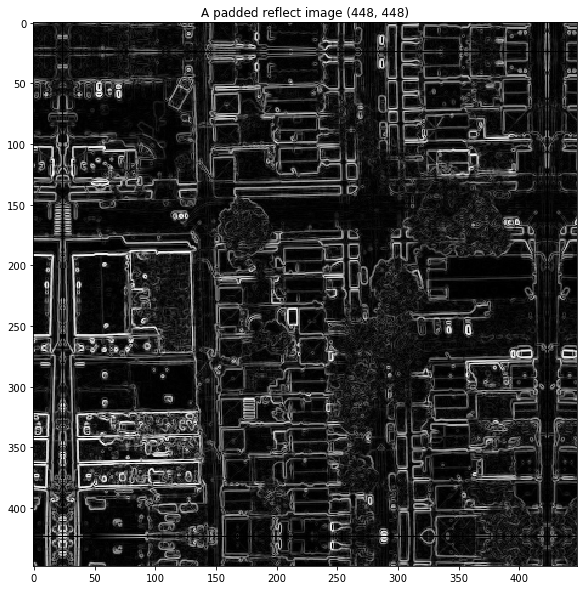

In [5]:
patch_size = 16
padding = 24

image = sch_imgs[3]
gt_image = gt_imgs[3]

padded_patch_size = patch_size + padding * 2

padded_image = pad_image(image, padding, True)

fig1 = plt.figure(figsize=(10, 10))
plt.title("A padded reflect image " + str(padded_image.shape))
plt.imshow(padded_image, cmap='Greys_r');

There are 625 patches of 64*64 for the image


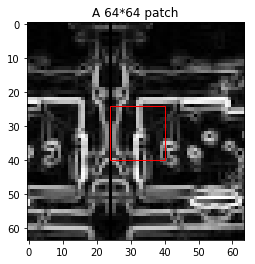

In [6]:
padded_img_patches = get_patches(padded_image, patch_size, patch_size, padding)

print("There are", len(padded_img_patches), 'patches of ' + str(padded_patch_size) + '*' +  str(padded_patch_size) + ' for the image')


fig,ax = plt.subplots(1)
plt.title('A ' + str(padded_patch_size) + '*' +  str(padded_patch_size) + ' patch')

plt.imshow(padded_img_patches[5], cmap='Greys_r');
rect = matplotlib_patches.Rectangle((padding,padding), patch_size, patch_size,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

Now we can see clearly that the center (the image inside the red square)of this padded image is not a road.

## Data augmentation
The dataset contains only 100 examples.
In order to increase the dataset, we can do the following transformation : 
- 90 degree rotation
- Horizontal flip
- Vertical flip

(64, 64)


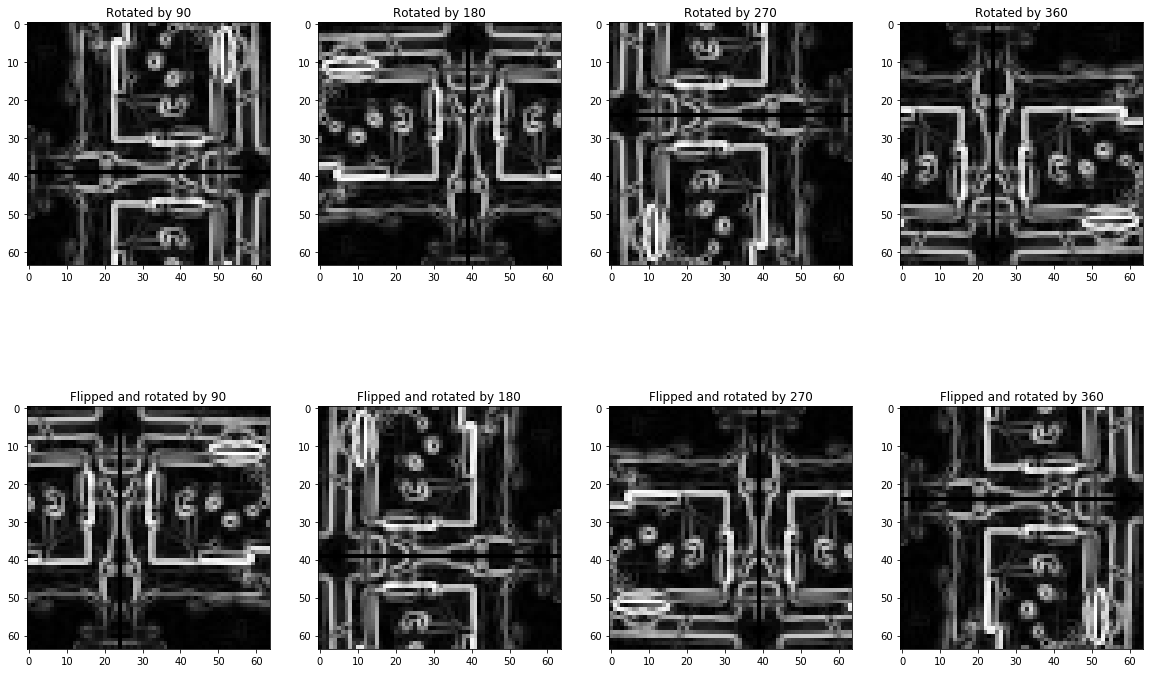

In [7]:
image_to_transform = padded_img_patches[5]
transformed_images = [np.rot90(image_to_transform, i+1) for i in range(4)]

for i in range(4):
    transformed_images.append(np.rot90(np.flip(image_to_transform, 0), i))


plt.figure(figsize=(20,20))
columns = 4
for i, transformed_image in enumerate(transformed_images):
    plt.subplot(len(transformed_images) / columns + 1, columns, i + 1)
    
    if i < 4:
        plt.title('Rotated by ' +str((i+1)*90))
    else:
        plt.title('Flipped and rotated by ' +str((i-3)*90))
    
    plt.imshow(transformed_image, cmap='Greys_r')
print(transformed_image.shape)

## X and Y
We create our training set.
- X : array of list of all patches
- Y : array of corresponding label

In [8]:
bw = True

if bw:
    images = sch_imgs
else:
    images = imgs

padded_images = pad_list_image(images, padding, bw)
patches = [get_patches(image, patch_size, patch_size, padding) for image in padded_images]
patches = [patch for image_patches in patches for patch in image_patches] # Flatten the array of patches to array of patch

gt_patches = [get_patches(gt_image, patch_size, patch_size, 0) for gt_image in gt_imgs]
gt_patches = [patch for image_patches in gt_patches for patch in image_patches] # Flatten (same thing)

print("There are", len(gt_patches), "patches")

There are 62500 patches


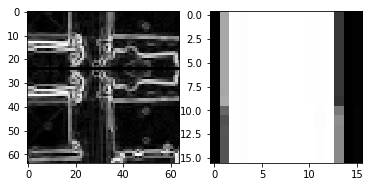

In [9]:
patch_size = 16
gt_img_patches = get_patches(gt_image, patch_size, patch_size, 0)

patch_index = 525

plt.subplot(1, 2, 1)
plt.imshow(patches[patch_index], cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(gt_patches[patch_index], cmap='Greys_r');


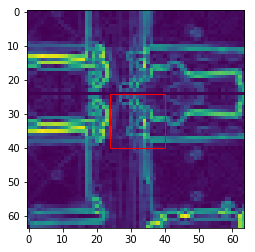

In [10]:
fig,ax = plt.subplots(1)
ax.imshow(patches[patch_index])
rect = matplotlib_patches.Rectangle((padding,padding), patch_size, patch_size,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()


### X has only 2 dimensions in black and white, need to be 3D for the CNN
Change the dimension to (w,h,1)

In [11]:
X = np.array(patches)
print(X.shape)
if bw:
    X = np.expand_dims(X, axis=3)
print(X.shape)
print(X[0])
Y_labels = np.array(list(map(lambda x: patch_to_label(x), gt_patches)))
Y_categorical = keras.utils.to_categorical(Y_labels, num_classes=2)

(62500, 64, 64)
(62500, 64, 64, 1)
[[[ 0.06433065]
  [ 0.04618911]
  [ 0.01906888]
  ..., 
  [ 0.04629304]
  [ 0.07241517]
  [ 0.09198233]]

 [[ 0.03285777]
  [ 0.01736049]
  [ 0.01196972]
  ..., 
  [ 0.16132926]
  [ 0.06474022]
  [ 0.04716147]]

 [[ 0.07384125]
  [ 0.07557053]
  [ 0.10657453]
  ..., 
  [ 0.2102034 ]
  [ 0.22737094]
  [ 0.32518229]]

 ..., 
 [[ 0.01887414]
  [ 0.00797981]
  [ 0.02697638]
  ..., 
  [ 0.0911544 ]
  [ 0.02017858]
  [ 0.029376  ]]

 [[ 0.02122753]
  [ 0.05123253]
  [ 0.03157962]
  ..., 
  [ 0.09308693]
  [ 0.04287465]
  [ 0.06787269]]

 [[ 0.03086484]
  [ 0.01319893]
  [ 0.04443581]
  ..., 
  [ 0.03365616]
  [ 0.07393719]
  [ 0.11255152]]]


#### Subsampling
There is more non-road than road patches in our dataset. We need to balance the set.

In [12]:
counter = collections.Counter(Y_labels)
count_to_keep = min(counter[0], counter[1])
print("There are", counter[0], "non-road patches")
print("There are", counter[1], "road patches")
print("Need to keep", count_to_keep, "patches")

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.array([0, 1]), Y_labels)
class_weight = dict(enumerate(class_weight))
class_weight

There are 46309 non-road patches
There are 16191 road patches
Need to keep 16191 patches


{0: 0.67481483081042559, 1: 1.9300846149095177}

In [13]:
# Old instead use class weight
X_balanced = []
Y_balanced_labels = []
road_count = 0
non_road_count = 0
for i in range(len(X)):
    if Y_labels[i] == 1 and road_count < count_to_keep:
        X_balanced.append(X[i])
        Y_balanced_labels.append(Y_labels[i])
        road_count += 1
    elif Y_labels[i] == 0 and non_road_count < count_to_keep:
        X_balanced.append(X[i])
        Y_balanced_labels.append(Y_labels[i])
        non_road_count += 1
        
X_balanced = np.array(X_balanced)
Y_balanced_labels = np.array(Y_balanced_labels)
Y_balanced_categorical = keras.utils.to_categorical(Y_balanced_labels, num_classes=2)

## Building the convolutional neural network

In [14]:


input_shape = X[0].shape

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])




### Split to train and test

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.1, random_state=40)


In [16]:
batch_size = 64

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# datagen.fit(X)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
# for X_batch, y_batch in train_generator:
#     for i in range(0, 9):
#         plt.subplot(330 + 1 + i)
#         plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
#     plt.show()
#     break

In [19]:
# k = 6
# plt.imshow(x_train[k].reshape((x_train[0].shape[0],x_train[0].shape[1])), cmap='Greys_r')
# print(y_train[k])

ValueError: cannot reshape array of size 12288 into shape (64,64)

In [17]:
epochs = 160

# model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               shuffle=True)

model.fit_generator(train_generator,
                    epochs=epochs,
                    steps_per_epoch=879,
                    shuffle=True,
                    class_weight=class_weight,
                    callbacks=[TensorBoard(log_dir='/tmp/model')])


Epoch 1/160
879/879 [==============================] - 147s 167ms/step - loss: 0.6173 - acc: 0.6372
Epoch 2/160
879/879 [==============================] - 137s 156ms/step - loss: 0.5462 - acc: 0.7070
Epoch 3/160
879/879 [==============================] - 139s 158ms/step - loss: 0.4957 - acc: 0.7476
Epoch 4/160
879/879 [==============================] - 139s 158ms/step - loss: 0.4569 - acc: 0.7734
Epoch 5/160
879/879 [==============================] - 138s 157ms/step - loss: 0.4320 - acc: 0.7920
Epoch 6/160
879/879 [==============================] - 138s 157ms/step - loss: 0.4144 - acc: 0.8043
Epoch 7/160
879/879 [==============================] - 138s 158ms/step - loss: 0.4024 - acc: 0.8109
Epoch 8/160
879/879 [==============================] - 138s 156ms/step - loss: 0.3872 - acc: 0.8196
Epoch 9/160
879/879 [==============================] - 138s 156ms/step - loss: 0.3784 - acc: 0.8261
Epoch 10/160
879/879 [==============================] - 137s 156ms/step - loss: 0.3632 - acc: 0.8322

879/879 [==============================] - 137s 156ms/step - loss: 0.2093 - acc: 0.9138
Epoch 83/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2089 - acc: 0.9128
Epoch 84/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2098 - acc: 0.9158
Epoch 85/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2144 - acc: 0.9147
Epoch 86/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2140 - acc: 0.9147
Epoch 87/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2116 - acc: 0.9141
Epoch 88/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2106 - acc: 0.9159
Epoch 89/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2086 - acc: 0.9167
Epoch 90/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2110 - acc: 0.9144
Epoch 91/160
879/879 [==============================] - 137s 156ms/step - loss: 0.2089 - acc: 0.9157
Epo

###  Save weights


In [18]:
model.save_weights("./weights/model_santi.h5")

###  Display a prediction vs ground truth



625/625 [==============================] - 1s 945us/step


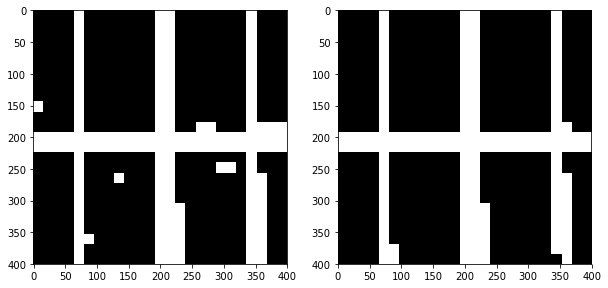

In [19]:
pred_img, gt_image = display_prediction_and_gt(model, X, Y_labels, 400, 16, 0)

In [20]:
predictions = model.predict_classes(X[:625 * 3])
save_labels_to_images(400, 400, patch_size, patch_size, predictions)

1875/1875 [==============================] - 5s 3ms/step
Saving predictions/prediction_1.png
Saving predictions/prediction_2.png
Saving predictions/prediction_3.png


## Test data

In [21]:
# Free some memory
del predictions
del padded_images
del patches
del X
del Y

NameError: name 'Y' is not defined

In [22]:
TEST_IMG_SIZE = 608

In [25]:
test_dir = "datas/test_set_images/"
files = os.listdir(test_dir)
n = min(100, len(files))  # Load maximum 20 images
files.sort()
print("Loading " + str(n) + " images")
test_imgs = [load_image(test_dir + files[i] + '/' + os.listdir(test_dir + files[i])[0]) for i in range(n)]
bw_test_imgs = [load_image_pil(test_dir + files[i] + '/' + os.listdir(test_dir + files[i])[0], bw=True) for i in range(n)]
print("Loaded !")

Loading 50 images
Loaded !


In [30]:
sch_test_imgs = [scharr(bw_im) for bw_im in bw_test_imgs]


if bw:
    images = sch_test_imgs
else:
    images = test_imgs

test_padded_images = pad_list_image(images, padding, bw)
test_patches = [get_patches(image, patch_size, patch_size, padding) for image in test_padded_images]
test_patches = [patch for image_patches in test_patches for patch in
                image_patches]  # Flatten the array of patches to array of patch

test_X = np.array(test_patches)

if bw:
    test_X = np.expand_dims(test_X, axis=3)

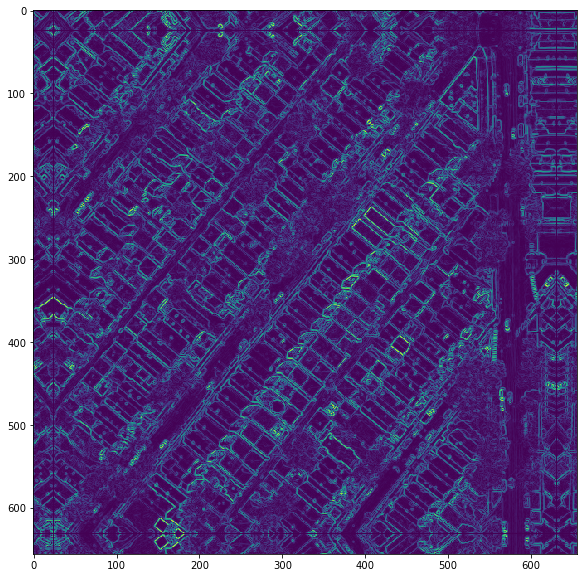

1444/1444 [==============================] - 2s 1ms/step


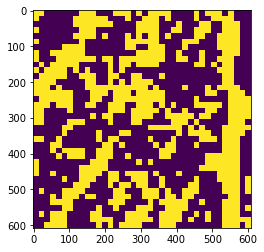

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(test_padded_images[len(test_padded_images) - 1]);
plt.show()
test_label = label_to_img(TEST_IMG_SIZE, TEST_IMG_SIZE, patch_size, patch_size, model.predict_classes(test_X[-1444:]))
plt.imshow(test_label);

In [32]:
predictions = model.predict_classes(test_X)
save_labels_to_images(TEST_IMG_SIZE, TEST_IMG_SIZE, patch_size, patch_size, predictions)


72200/72200 [==============================] - 51s 712us/step
Saving predictions/prediction_1.png
Saving predictions/prediction_2.png
Saving predictions/prediction_3.png
Saving predictions/prediction_4.png
Saving predictions/prediction_5.png
Saving predictions/prediction_6.png
Saving predictions/prediction_7.png
Saving predictions/prediction_8.png
Saving predictions/prediction_9.png
Saving predictions/prediction_10.png
Saving predictions/prediction_11.png
Saving predictions/prediction_12.png
Saving predictions/prediction_13.png
Saving predictions/prediction_14.png
Saving predictions/prediction_15.png
Saving predictions/prediction_16.png
Saving predictions/prediction_17.png
Saving predictions/prediction_18.png
Saving predictions/prediction_19.png
Saving predictions/prediction_20.png
Saving predictions/prediction_21.png
Saving predictions/prediction_22.png
Saving predictions/prediction_23.png
Saving predictions/prediction_24.png
Saving predictions/prediction_25.png
Saving predictions/pre